In [7]:
import simpy 
import numpy as np
import math, itertools
import sys, os

class P:
    # This is a class that contains all the parameters (P) for a Simulation
    externalToMean = 0.6
    orderLotSize = 10
    Q = 20
    ROP = 20+(200/30)*7
    LT = 2
    simulationTimeMax = 12*30
    
class S :
    # This is a class that defines a Simulation (S)
    Inv = None
    Waits = [ ]
    nCustomers = 0
    Dem_day = list(itertools.repeat(0, P.simulationTimeMax))
    
class Inventory:
    def __init__(self, env):
        self.env = env
        self.inv = simpy.Container(env, init = P.ROP)
        self.mon_proc = env.process(self.monitor_inv(env))
        self.inv_dataset = []

    def monitor_inv(self, env):
        while True :
            self.inv_dataset.append(self.inv.level)
            if self.inv.level <= P.ROP:
                print('Time {:.2f}: inventory reached ROP: places replenishment order. Inv: {:.2f}'.format(self.env.now, self.inv.level))
                yield self.env.timeout(P.LT)
                print('Time {:.2f}: replenishment inventory arrives'.format(self.env.now))
                yield self.inv.put(P.Q)
                print('Time {:.2f}: replenishment order is added to inventory. Inv: {:.2f}'.format(self.env.now, self.inv.level))
            yield self.env.timeout(1)
            
class Customer(object):
    def __init__(self, env , name = '' ):
        self.env = env
        self.action = self.env.process(self.order())
        if(name == ''):
            self.name = 'RandomCustomer' + str(np.random.randint(100))
        else:
            self.name = name

    def order(self):
        startTime = self.env.now
        j = math.floor(self.env.now)
        S.Dem_day[j] += 1
        customer_order = np.random.uniform(3,10)
        print('Time {:.2f}: {} places order of {:.2f}'.format(self.env.now, self.name, customer_order))
        yield S.Inv.inv.get(customer_order)
        print('Time {:.2f}: Customer {} recieves order'.format(self.env.now, self.name))
        waitTime = self.env.now - startTime
        print('Custome {} had to wait {:.2f} days'.format(self.name, waitTime))
        S.Waits.append(waitTime)
        
class OrderProcessor(object):
    def __init__(self, env, WHlambda):
        self.env = env
        self.action = env.process(self.Entrance())
        self.lam = WHlambda
        
    def Entrance(self):
        while True:
            interarrivalTime = np.random.exponential(scale = 1/P.externalToMean)
            yield self.env.timeout(interarrivalTime)
            c = Customer(self.env, name = 'Customer {0}'.format(S.nCustomers))
            S.nCustomers += 1
            
# Disable
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys.stdout = sys.__stdout__

def model(randomSeed = 123):
    #blockPrint()
    np.random.seed(randomSeed)
    S.Waits = []
    envr = simpy.Environment()
    WH = OrderProcessor(envr, WHlambda = P.externalToMean)
    S.Inv = Inventory(envr)
    envr.run(until = P.simulationTimeMax)
    #enablePrint()
    return S.Inv.inv, S.Waits, S.Dem_day, S.nCustomers , S.Inv.inv_dataset

Results = model()

Time 0.00: inventory reached ROP: places replenishment order. Inv: 66.67
Time 1.99: Customer 0 places order of 4.59
Time 1.99: Customer Customer 0 recieves order
Custome Customer 0 had to wait 0.00 days
Time 2.00: replenishment inventory arrives
Time 2.00: replenishment order is added to inventory. Inv: 82.08
Time 2.55: Customer 1 places order of 8.04
Time 2.55: Customer Customer 1 recieves order
Custome Customer 1 had to wait 0.00 days
Time 3.88: Customer 2 places order of 9.87
Time 3.88: Customer Customer 2 recieves order
Custome Customer 2 had to wait 0.00 days
Time 4.00: inventory reached ROP: places replenishment order. Inv: 64.18
Time 4.80: Customer 3 places order of 6.37
Time 4.80: Customer Customer 3 recieves order
Custome Customer 3 had to wait 0.00 days
Time 6.00: replenishment inventory arrives
Time 6.00: replenishment order is added to inventory. Inv: 77.81
Time 6.73: Customer 4 places order of 5.40
Time 6.73: Customer Customer 4 recieves order
Custome Customer 4 had to wai

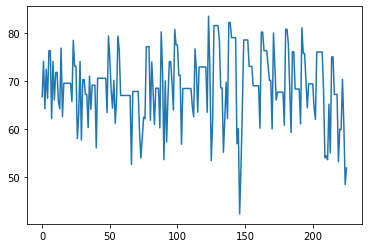

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(Results[4])
plt.show()

In [27]:
sys.stdout = sys.__stdout__
print('3')